In [251]:
!uv pip install fitparse tqdm numpy matplotlib pillow
# !uv pip install gpxpy==1.6.2 fitdecode==0.10.0 pandas==1.5.3 --no-cache-dir
# !uv pip install fit2gpx==1.0.0 --no-cache-dir

Using Python 3.10.6 environment at: /Users/jackstanley/venv/jupyter
Audited 5 packages in 24ms
Using Python 3.10.6 environment at: /Users/jackstanley/venv/jupyter
Audited 3 packages in 59ms
Using Python 3.10.6 environment at: /Users/jackstanley/venv/jupyter
Audited 1 package in 32ms


### Unzip export directory and all .fit files

In [1]:
import os
import gzip
from tqdm import tqdm

zip = None
for file in os.listdir():
    if file.endswith('.zip'):
        zip = file
        break
if zip is None:
    raise Exception('No zip file found')
unzipped = zip.replace('.zip', '')
if os.path.exists(unzipped):
    print(f'Found existing {unzipped}')
else:
    print(f'Unzipping {zip}')
    os.system(f'unzip {zip} -d {unzipped}')

activities_dir = os.path.join(unzipped, 'activities')
if not os.path.exists(activities_dir):
    raise Exception('No activities folder found')
print(f'Unzipping {len(os.listdir(activities_dir))} directories')
activity_paths = []
for filename in tqdm(os.listdir(activities_dir)):
    if filename.endswith('.fit.gz'):
        filepath = os.path.join(activities_dir, filename)
        output_filepath = os.path.join(activities_dir, filename[:-3]) # Remove .gz extension
        try:
            with gzip.open(filepath, 'rb') as f_in:
                with open(output_filepath, 'wb') as f_out:
                    f_out.writelines(f_in)
                    activity_paths.append(output_filepath)
        except Exception as e:
            print(f"Error extracting {filename}: {e}")

Found existing export_59042520
Unzipping 3113 directories


100%|████████████████████████████████████████████████████████████| 3113/3113 [00:01<00:00, 1731.07it/s]


### Convert .fit files to .gpx

In [2]:
# from fit2gpx import Converter

# conv = Converter()
# conv.fit_to_gpx_bulk(dir_in='./activities', dir_out='./activities_gpx')

In [27]:

from fitparse import FitFile

def semicircles_to_degrees(lat_sc, lon_sc):
    """
    Convert Garmin semicircle format to degrees
    """
    lat = lat_sc * (180 / 2**31)
    lon = lon_sc * (180 / 2**31)
    return lat, lon

if os.path.exists('coords.pkl'):
    with open('coords.pkl', 'rb') as file:
        coords = pickle.load(file)
    print(f'Loaded {len(coords)} coordinates from pickle file')
else:
    coords = []
    for activity_path in tqdm(activity_paths):
        fitfile = FitFile(activity_path, check_crc=False)
        for record in fitfile.get_messages('record'):
          lat = record.get_value('position_lat')
          lon = record.get_value('position_long')
          if lat is None or lon is None:
              continue
          lat, lon = semicircles_to_degrees(lat, lon)
          ele = record.get_value('enhanced_altitude')
          coords.append((lat, lon, ele))

    print(f'Loaded {len(coords)} coordinates')


Loaded 1283905 coordinates from pickle file


In [28]:
import pickle 
with open('coords.pkl', 'wb') as f:
    pickle.dump(coords, f)

In [97]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import math

def get_rect(ul_coord, miles):
    ul_lat, ul_lon = ul_coord
    
    miles_per_deg_lat = 69.0
    miles_per_deg_lon = 69.0 * math.cos(math.radians(ul_lat))
    
    delta_lat = miles / miles_per_deg_lat
    delta_lon = miles / miles_per_deg_lon
    
    lr_lat = ul_lat - delta_lat
    lr_lon = ul_lon + delta_lon
    
    return (ul_coord, (lr_lat, lr_lon))


# tuple of (upper-left-tuple, bottom-right-tuple)
# princeton = ((40.415217, -74.797882), (40.282776, -74.548656))
princeton = get_rect((40.430217, -74.767882), 12)
boulder = get_rect((40.111741, -105.365283), 20)
duke = get_rect((36.031007, -79.014064), 7)
mendham = get_rect((40.896692, -74.845338), 25)

bounds = princeton
ul_lat, ul_lon = bounds[0]
br_lat, br_lon = bounds[1]

in_bounds = lambda x: x[0] < bounds[0][0] and x[0] >= bounds[1][0] and \
            x[1] > bounds[0][1] and x[1] <= bounds[1][1]
filtered_coords = filter(in_bounds, coords)

width, height = 2048, 2048
img_array = np.zeros((width, height))
img_gauss = np.zeros((width, height))

def latlon_to_pixel(lat, lon):
    """
    Convert lat/lon to pixel coordinates in the image.
    Y axis is top-to-bottom (latitude decreases downward)
    X axis is left-to-right (longitude increases rightward)
    """
    x = int((lon - ul_lon) / (br_lon - ul_lon) * width)
    y = int((ul_lat - lat) / (ul_lat - br_lat) * height)
    # Clamp to image bounds
    x = max(0, min(width - 1, x))
    y = max(0, min(height - 1, y))
    return x, y

def add_gaussian(img, x0, y0, sigma=20):
    """
    Add a 2D Gaussian centered at (x0, y0) to the image array
    """
    size = int(sigma*3)
    x_min = max(0, x0 - size)
    x_max = min(width, x0 + size)
    y_min = max(0, y0 - size)
    y_max = min(height, y0 + size)
    
    x = np.arange(x_min, x_max)
    y = np.arange(y_min, y_max)
    xv, yv = np.meshgrid(x, y)
    
    g = np.exp(-((xv - x0)**2 + (yv - y0)**2) / (2*sigma**2))
    img[y_min:y_max, x_min:x_max] += g

# img_array = np.zeros((20, 20))
# add_gaussian(img_array, 5, 5)

# # Add all coordinates
for lat, lon, ele in tqdm(list(filtered_coords)):  # coords in semicircles
    x, y = latlon_to_pixel(lat, lon)
    # add_gaussian(img_gauss, x, y, sigma=2)
    img_array[int(y), int(x)] += 1

100%|█████████████████████████████████████████████████████| 460847/460847 [00:00<00:00, 1144936.64it/s]


### Clip to 255

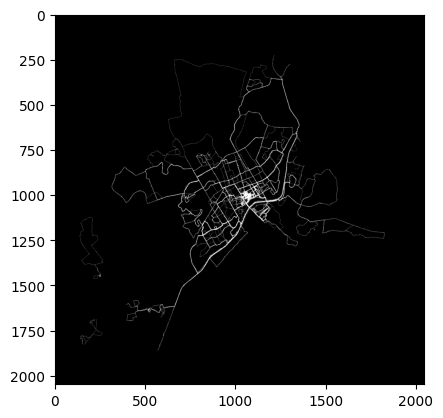

In [98]:
clipped = np.clip(img_array * 255, 0, 255).astype(np.uint8)
plt.imshow(clipped, cmap='gray')
plt.show()
img = Image.fromarray(clipped)
img.save('clip255.png')

### Clip with gaussian

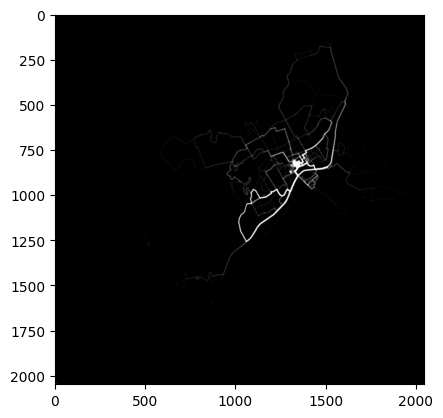

In [6]:
clipped = np.clip(img_gauss, 0, 255).astype(np.uint8)
plt.imshow(clipped, cmap='gray')
plt.show()
img = Image.fromarray(clipped)
img.save('clip_gauss.png')

In [ ]:
### Exponential rescale

In [ ]:
img_array_norm = (img_array / img_array.max())
expon = (np.power(img_array_norm, 1/2) * 255).astype(np.uint8)
plt.imshow(img_array_clipped, cmap='gray')
plt.show()

### Gradients

In [ ]:
import importlib
import gradient
importlib.reload(gradient)

g = gradient.Gradient.cool()

g.eval(np.array([0, 0.2, 1]))

Normalize nonzero values linearly from 0 to 1

In [ ]:
shape = image_array.shape
a = np.array([[1,3, 0, 0], [2, 23, 0, 4],[0,0,5,0]], dtype=np.float32).reshape((-1))
nonzeros = np.count_nonzero(a)
rng = np.linspace(0, 1, nonzeros, dtype=np.float32)
a_sort = np.argsort(a)
nonzero_indices = a_sort[-nonzeros:]
print(nonzero_indices)
print(rng)
a[nonzero_indices] = rng
print(a)
a.reshape(3, 4)


In [ ]:
def eval_numpy(self, n):
    _n = n.copy()
    try:
      n = np.clip(n, 0, 1)  
      if (n <= 0):
          return self.colors[0]
      if (n >= 1):
          return self.colors[-1]
      i = 0
      while self.stops[i] <= n:
          i += 1
      start = self.stops[i-1]
      end = self.stops[i]
      rat = (n - start) / (end - start)
      color = [0,0,0]
      for j in range(3):
        color[j] = (self.colors[i][j] - self.colors[i-1][j]) * rat + self.colors[i-1][j]
    except IndexError:
        print('Error', start, end, rat)
    return color

g = gradient.Gradient.heat()

eval(g, np.array([0, 0.5, 1]))